# 06wk-1: 딥러닝의 기초 (6)

최규빈  
2022-10-06

> 깊은신경망(2)– 시벤코정리, MNIST with DNN

# 강의영상

> <https://youtube.com/playlist?list=PLQqh36zP38-x9XuXWwAmKKI3JbTRoXVJA>

# imports

In [1]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import * 
import torchvision

# 시벤코정리

## 지난시간 논리전개

`-` 아이디어: linear -\> relu -\> linear (-\> sigmoid) 조합으로
꺽은선으로 표현되는 underlying 을 표현할 수 있었다.

-   아이디어의 실용성: 실제자료에서 꺽은선으로 표현되는 underlying은
    몇개 없을 것 같음. 그건 맞는데 꺽이는 점을 많이 설정하면 얼추
    비슷하게는 “근사” 시킬 수 있음.
-   아이디어의 확장성: 이러한 논리전개는 X:(n,2)인 경우도 가능했음. (이
    경우 꺽인선은 꺽인평면이 된다)
-   아이디어에 해당하는 용어정리: : 이 구조가 x-\>y 로 바로 가는 것이
    아니라 x-\>(u1-\>v1)-\>(u2-\>v2)=y 의 구조인데 이러한 네트워크를
    하나의 은닉층을 포함하는 네트워크라고 표현한다.

### 시벤코정리

**universal approximation thm: (범용근사정리,보편근사정리,시벤코정리)**,
1989

> 하나의 은닉층을 가지는 “linear -\> sigmoid -\> linear” 꼴의 네트워크를
> 이용하여 세상에 존재하는 모든 (다차원) 연속함수를 원하는 정확도로
> 근사시킬 수 있다. (계수를 잘 추정한다면)

`-` 사실 엄청 이해안되는 정리임. 왜냐햐면,

-   그렇게 잘 맞추면 1989년에 세상의 모든 문제를 다 풀어야 한거 아니야?
-   요즘은 “linear -\> sigmoid -\> linear” 가 아니라 “linear -\> relu
    -\> linear” 조합으로 많이 쓰던데?
-   요즘은 하나의 은닉층을 포함하는 네트워크는 잘 안쓰지 않나? 은닉층이
    여러개일수록 좋다고 어디서 본 것 같은데?

`-` 약간의 의구심이 있지만 아무튼 universal approximation thm에 따르면
우리는 아래와 같은 무기를 가진 꼴이 된다.

-   우리의 무기: ${\bf X}: (n,p)$ 꼴의 입력에서 ${\bf y}:(n,1)$ 꼴의
    출력으로 향하는 맵핑을 “linear -\> relu -\> linear”와 같은
    네트워크를 이용해서 “근사”시킬 수 있다.

# MNIST with DNN

## 목표

`-` 목표: ${\bf X}:(n,1,28,28)$ 에서 $y:(n,1)$ 로 가는 맵핑을 학습하자
–\> 배운적이 없는데? –\> ${\bf X}:(n,784)$ 에서 $y:(n,1)$ 로 가는 맵핑을
학습하자..

## 예비학습1: Path

In [2]:
path = untar_data(URLs.MNIST) 
path

-   path 도 오브젝트임
-   path 도 정보+기능이 있음

`-` path의 정보

In [3]:
path._str # 숨겨놓았네?

`-` 기능1

In [4]:
path.ls()

`-` 기능2

In [5]:
path/'training'

In [6]:
path/'testing'

`-` 기능1과 기능2의 결합

In [7]:
(path/'training/3').ls()

-   ‘/home/cgb4/.fastai/data/mnist_png/training/3/37912.png’ 이 파일을
    더블클릭하면 이미지가 보인단 말임

## 예비학습2: plt.imshow

In [8]:
imgtsr = torch.tensor([[1.0,2],[2.0,4.0]])
imgtsr

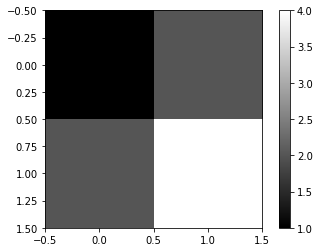

In [9]:
plt.imshow(imgtsr,cmap='gray')
plt.colorbar()

## 예비학습3: torchvision

`-` `/home/cgb4/.fastai/data/mnist_png/training/3/37912.png`의
이미지파일을 torchvision.io.read_image 를 이용하여 텐서로 만듬

In [10]:
imgtsr = torchvision.io.read_image('/home/cgb4/.fastai/data/mnist_png/training/3/37912.png')
imgtsr

`-` 이 텐서는 (1,28,28)의 shape을 가짐

In [11]:
imgtsr.shape

`-` imgtsr를 plt.imshow 로 시각화

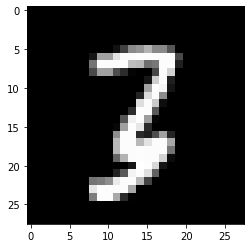

In [12]:
plt.imshow(imgtsr.reshape(28,28),cmap='gray')

-   진짜 숫자3이 있음

## 데이터정리

In [13]:
threes = (path/'training/3').ls()
sevens = (path/'training/7').ls()
len(threes),len(sevens)

In [14]:
X3 = torch.stack([torchvision.io.read_image(str(threes[i])) for i in range(6131)])
X7 = torch.stack([torchvision.io.read_image(str(sevens[i])) for i in range(6265)])

In [15]:
X3.shape,X7.shape

In [16]:
X=torch.concat([X3,X7])
X.shape

In [17]:
Xnp = X.reshape(-1,1*28*28).float()
Xnp.shape

In [18]:
y = torch.tensor([0.0]*6131 + [1.0]*6265).reshape(-1,1) 
y.shape

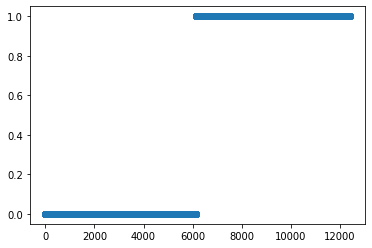

In [19]:
plt.plot(y,'o')

-   “y=0”은 숫자3을 의미, “y=1”은 숫자7을 의미
-   숫자3은 6131개, 숫자7은 6265개 있음

## 학습 (숙제: 스스로 확인해 볼 것)

`-` 네트워크의 설계

In [20]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1*28*28,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)

-   $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [21]:
loss_fn = torch.nn.BCELoss()

In [22]:
optimizr = torch.optim.Adam(net.parameters())

In [23]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

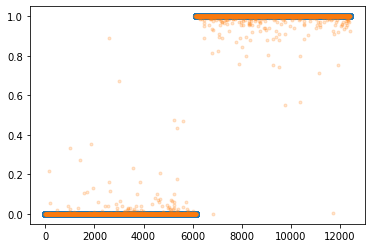

In [24]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

-   대부분 잘 적합되었음

# 숙제

<https://youtube.com/playlist?list=PLQqh36zP38-zEUnVaQveVvRD-eMBPtxIp>

`(1)` 숫자0과 숫자1을 구분하는 네트워크를 아래와 같은 구조로 설계하라

$$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,64)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,64)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

위에서 $a_1$은 relu를, $a_2$는 sigmoid를 의미한다.

-   “y=0”은 숫자0을 의미하도록 하고 “y=1”은 숫자1을 의미하도록 설정하라.

(풀이)

In [452]:
path = untar_data(URLs.MNIST)

In [453]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28).float()
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [454]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid())

`(2)` 아래의 지침에 따라 200 epoch 학습을 진행하라.

-   손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss() 를 이용할 것.
-   옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것.

(풀이)

In [455]:
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [456]:
for epoc in range(200):
    ## 1 
    yhat = net(X) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

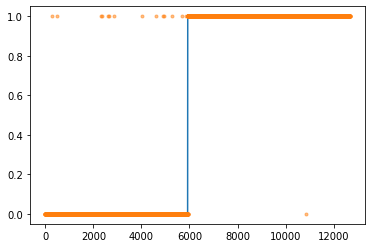

In [457]:
plt.plot(y)
plt.plot(yhat.data,'.',alpha=0.5)

`(3)` 아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가?

-   손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고
    수식을 직접 입력할 것.
-   옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것.

(풀이)

In [458]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid())

In [459]:
#loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [460]:
for epoc in range(200):
    ## 1 
    yhat = net(X) 
    ## 2 
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

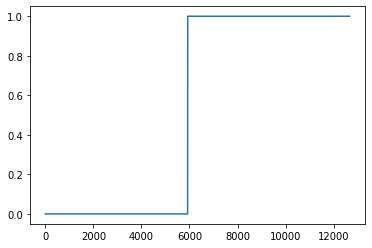

In [461]:
plt.plot(y)
plt.plot(yhat.data,'.',alpha=0.5)

In [462]:
yhat.data

-   학습이 잘 안되었다!

`(4)` 아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가?

-   이미지의 값을 0과 1사이로 규격화 하라. (Xnp = Xnp/255 를
    이용하세요!)
-   손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고
    수식을 직접 입력할 것.
-   옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것.

In [463]:
X = X/255 

In [464]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid())

In [465]:
#loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [466]:
for epoc in range(200):
    ## 1 
    yhat = net(X) 
    ## 2 
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

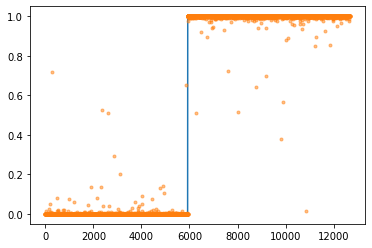

In [467]:
plt.plot(y)
plt.plot(yhat.data,'.',alpha=0.5)

-   이번엔 학습이 잘 되었다!

`(5)` 아래와 같은 수식을 이용하여 accuracy를 계산하라.

$\text{accuracy}=\frac{1}{n}\sum_{i=1}^n I(\tilde{y}_i=y_i)$

-   $\tilde{y}_i = \begin{cases}  1 & \hat{y}_i > 0.5 \\  0 & \hat{y}_i \leq 0.5 \end{cases}$
-   $I(\tilde{y}_i=y_i) = \begin{cases} 1 & \tilde{y}_i=y_i \\ 0 & \tilde{y}_i \neq y_i \end{cases}$

단, $n$은 0과 1을 의미하는 이미지의 수

(풀이1)

In [89]:
ytilde = (yhat>0.5)*1  # ytilde의 구현

-   $\tilde{y}_i = \begin{cases}  1 & \hat{y}_i > 0.5 \\  0 & \hat{y}_i \leq 0.5 \end{cases}$
    의 구현

In [91]:
(ytilde == y)*1 # I(ytilde =y)의 구현 

-   $I(\tilde{y}_i=y_i) = \begin{cases} 1 & \tilde{y}_i=y_i \\ 0 & \tilde{y}_i \neq y_i \end{cases}$
    의 구현

In [449]:
torch.sum((ytilde == y)*1) 

-   $\sum_{i=1}^n I(\tilde{y}_i=y_i)$의 계산

In [450]:
torch.sum((ytilde == y)*1)  / len(y)

-   $\text{accuracy}=\frac{1}{n}\sum_{i=1}^n I(\tilde{y}_i=y_i)$ 의 계산

(풀이2)

In [451]:
((yhat > 0.5) == y).sum() / len(y)

------------------------------------------------------------------------

***생각해볼점1: 왜 (2)는 학습이 잘되고 (3)은 학습이 잘 안되는가?***

`-` data

In [471]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28).float()
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` net초기화

In [479]:
torch.manual_seed(9)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid()
)

`-` loss_fn 정의

In [480]:
loss_fn1 = torch.nn.BCELoss()
loss_fn2 = lambda yhat,y: -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))

`-` loss_fn 적용결과 확인

In [483]:
loss_fn1(net(X),y), \
loss_fn2(net(X),y) 

-   loss_fn1(net(x),y) = 22.4927
-   loss_fn2(net(x),y) = nan (*해설영상에는 $\infty$라고 했는데
    정확하게는 nan입니다. nan은 $\infty \times 0$의 결과로 나오게 되고요
    $y_i=1,\hat{y}_i=1$ 인 경우에
    $-\frac{1}{n}\sum_{i=1}^{n}\big(y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)\big)$
    중 $(1-y_i)\log(1-\hat{y}_i)$의 계산결과로 발생할 수 있습니다.*)
-   왜?

`-` 처음 4개의 관측치에 대한 loss_fn 적용 결과: 같다.

In [488]:
loss_fn1(net(X)[:4], y[:4]),\
loss_fn2(net(X)[:4], y[:4])

`-` 처음 5개의 관측치에 대한 loss_fn 적용 결과: 다르다.

In [489]:
loss_fn1(net(X)[:5], y[:5]),\
loss_fn2(net(X)[:5], y[:5])

`-` 왜? 5번관측치에 문제가 있음

In [490]:
net(X)[:5], y[:5]

In [497]:
loss_fn1(net(X)[[5]], y[[5]]),\
loss_fn2(net(X)[[5]], y[[5]])

`-` loss_fn1은 사실 이런식으로 계산을 했음

In [502]:
(3.0566*4 + 100)/5, loss_fn1(net(X)[:5], y[:5]).item()

`-` loss function에 대한 엄밀한 정의는 아닌데 $\infty =100$ 으로
생각하는 것이 오히려 효율적이다.

***생각해볼점2: 왜 (3)은 학습이 잘 안되는데 (4)는 학습이 잘 되는가?***

`-` 아래의 상황을 다시 생각하자.

In [503]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28).float()
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [504]:
torch.manual_seed(9)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid()
)

`-` (3)에서 학습이 불가능했던 만악의 근원은 $y=0$ 인데 $yhat \approx 1$
인 상황 이었다. ($y=1$인데 $yhat \approx 0$ 인 상황도 마찬가지) - 그런데
왜 초기값에 $yhat\approx 1$ 과 같은 값이 들어있는 거야?

`-` 네트워크를 분해하자.

In [505]:
l1,a1,l2,a2 = net 

`-` 5번관측치 `X[[5]]`를 콕 찍어서 생각해보자.

In [513]:
l2(a1(l1(X[[5]])))

In [515]:
torch.exp(torch.tensor(21.7626)) # 이거 너무 큰 값이 나옴 => 사실상 무한대라고 봐도 무방한 값

In [516]:
torch.exp(torch.tensor(21.7626))/(torch.exp(torch.tensor(21.7626))+1)

`-` 만약에 하나의 관측치 X\[\[5\]\]의 범위를 0~1 사이로 맞춘다면?

In [524]:
l2(a1(l1(X[[5]]/255)))

In [526]:
torch.exp(torch.tensor(0.1216)) # 적당한 값이 나옴

In [527]:
torch.exp(torch.tensor(0.1216))/(torch.exp(torch.tensor(0.1216))+1)

In [531]:
loss_fn2(net(X[[5]]),y[[5]]),\
loss_fn2(net(X[[5]]/255),y[[5]]),

`-` 깨달음1

-   X가 0~255사이의 값을 가지면
    $X \to u^{(1)} \to v^{(1)} \to u^{(2)} \to yhat$ 의 구조에서
    $u^{(2)}$의 값이 클 확률이 높다. (예를들면 21.7626 같은 값)
-   큰 $u^{(2)}$의 값은 $yhat \approx 1$ 이 되는 상황을 야기한다.
-   $yhat \approx 1$인 상황은 $loss=\infty$인 상황을 야기한다.
-   그래서 학습이 안된다.

`-` 깨달음2

-   X가 0~1사이의 값을 가지면
    $X \to u^{(1)} \to v^{(1)} \to u^{(2)} \to yhat$ 의 구조에서
    $u^{(2)}$의 값이 클 확률이 적다. (예를들면 0.1216와 같이 적당한 값이
    나옴)
-   적당한 크기의 $u^{(2)}$의 값은 $yhat \approx 1$ 이 되는 상황을
    만들지 않는다.
-   그래서 $loss=\infty$인 상황도 잘 생기지 않는다.
-   그래서 학습이 (상대적으로) 잘된다.